In [1]:
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt

from ipynb.fs.full.mie_functions import *

In [2]:
# Import wavelength and refractive index values
ref_lam_silver, ref_n_silver, ref_k_silver = import_data("McPeak_silver.csv")
m_silver = ref_n_silver + 1j * ref_k_silver # SIGN!!!!!!!!
ref_lam_gold, ref_n_gold, ref_k_gold = import_data("McPeak_gold.csv")
m_gold = ref_n_gold + 1j * ref_k_gold # SIGN!!!!!!!!

In [3]:
# Define constants
hbar = 1.054571817e-34 # [Js]   1 [au]
d_eg = 8.4783536198e-30 # 1 [au]
c = 299792458 # [m/s] divide by (2.187691 * (10**6)) for [au]
dperm = 0.9*d_eg
r = 0.01 #micrometers

### Field Enhancement by Silver Nanoparticle

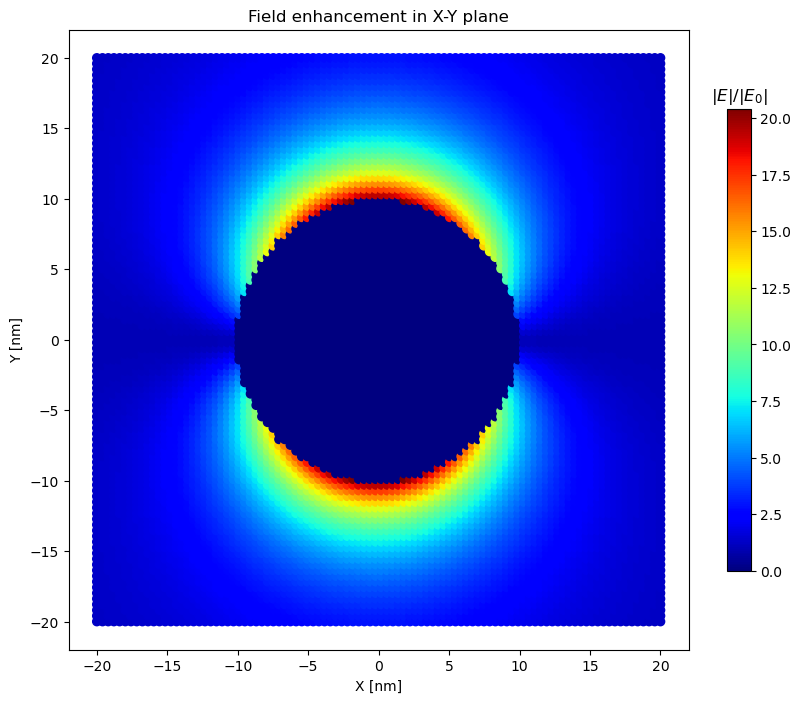

('At incoming wavelength of 360000000.0 nm',
 'Maximum scattered field = 20.422256542018516 E_0')

<Figure size 640x480 with 0 Axes>

In [4]:
x_arr = np.linspace(-20.0,20.0,100) #nm
y_arr = np.linspace(-20.0,20.0,100)

plot_scattered_field(x_arr, y_arr, 1e-15, m_silver, lam_list = ref_lam_silver, lam_value = 0.36, r = r, filename = 'defaultFile.txt', n = 1)

### Rabi frequency and decay rates of the TLS 
(as a function of distance from the surface of the nanosphere)

In [5]:
def rabi_frequency(x_points, y, z, refr_ind, lam_list, r, E_0 = 0.01, n = 1, lam_value = 0.36, print_vals = False):
    
    """ Calculates Rabi frequency for TLS with and without PDM in the vicinity of spherical nanoparticles.
        Inputs:  x_points [float]: array of x coordinates of the TLS [nm]
                 y [float]: y coordinate of the TLS [nm]
                 z [float]: z coordinate of the TLS [nm]
                 NOTE: [x,y,z] = [0,0,0] corresponds to center of nanosphere
                 refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. REFR_IND must be of the form
                 real(n) + 1j*imag(n) [unitless]
                 lam_list [float]: wavelengths corresponding to REFR_IND [micrometers] 
                 r [float]: radius of the nanosphere [micrometers]
                 E_0 [float]: amplitude of the incident electric field [au]
                 n [int]: order at which the bessel function expansions of the Mie coefficients are terminated
                 lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [micrometers]
                 print_vals [bool]: if True, values of the frequency, intensity and enhancement of the incident field are outputed
                 together with the argument of the Bessel function correction due to the PDM
        Outputs: J_factor [float]: correction to the Rabi frequency due to the PDM of the TLS
                 E_0val [float]: incident electric field in V/m
                 omega_np [float]: uncorrected Rabi frequency i.e. Rabi frequency for TLS without PDM
                 omega [float]: corrected Rabi frequency """
    
    # Rescale coordinates to meters
    x_vals = x_points*1.0e-9 # nm --> m
    y_val = y*1.0e-9 # nm --> m
    z_val = z*1.0e-9 # nm --> m
    E_0val = E_0*5.14220675112*1e11
    # Find refractive index at wavelength LAM_VALUE
    index = np.where(lam_list == lam_value)
    m_value = refr_ind[index]  
    #Rescale input parameters to meters
    lam_vals = lam_list * 1e-6 # micrometers --> m
    lam_val = lam_value * 1e-6 # micrometers --> m
    rad = r * 1e-6 # micrometers --> m
    # Build arrays of points and scattered fields
    E = np.zeros_like(x_vals)
    ind = 0
    for i in x_vals:
        if i**2 + y_val**2 < rad**2:
             E[ind] = 0
        else:
            E[ind] += E_0val * scattered_field_absolute(i, y_val, z_val, refr_ind, lam_vals, rad, lam_val, n = 1)[0] # in V/m
        ind += 1

    w = 2*np.pi*c/lam_val
    omega_np = E*d_eg/hbar
    kappa = E*dperm/(hbar * w)
    if print_vals:
        print('w', w)
        print('E-field', E)
        print('E/E0', E/E_0val)        
        print('kappa', kappa)
    J_factor = sp.jv(0, kappa) #equal to 2*sp.jv(1,kappa)/kappa 
    omega = omega_np*J_factor
    return J_factor, E_0val, omega_np, omega

In [6]:
x_arr = np.linspace(1.0, 2.0, 100) * 10  #nm
y_arr = np.array([0.0]) 
J_factor, E, omega_np, omega = rabi_frequency(x_points = x_arr, y = y_arr[0], z = 1e-15, refr_ind = m_silver, \
                                           lam_list = ref_lam_silver, r = r, n = 1, lam_value = 0.36, E_0 = 0.01, print_vals = False)

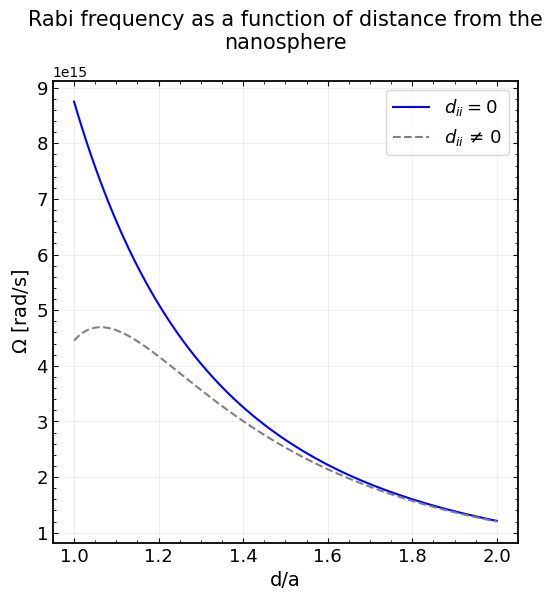

In [7]:
y_vals = np.ones_like(x_arr)*y_arr[0]
r_arr = np.sqrt(x_arr**2 + y_vals**2)
general_plot_style(x = [r_arr/(r*1e3), r_arr/(r*1e3)], y = [omega_np, omega], legendlabels = ['$d_{ii} = 0$', u'$d_{ii}$ \u2260 $0$'], \
                   colors = ['blue', 'grey'], ls = ['solid', '--'], ylims = None, xlabel = 'd/a', ylabel = '$\Omega$ [rad/s]', \
                   title = 'Rabi frequency as a function of distance from the nanosphere', figsize = [6,6])

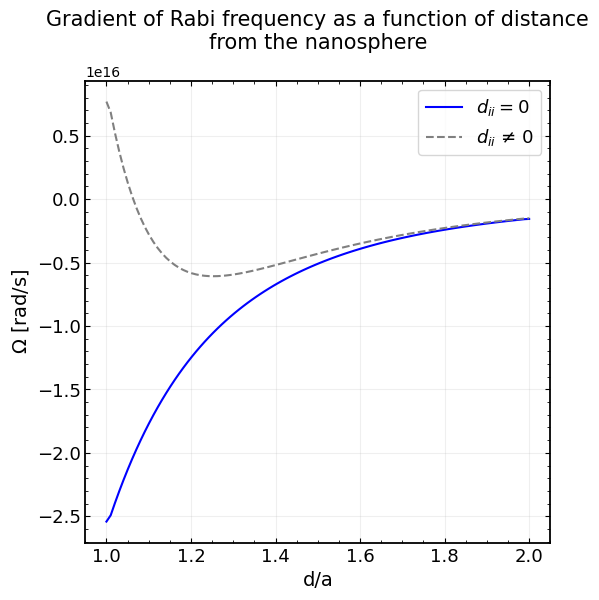

In [8]:
general_plot_style(x = [r_arr/(r*1e3), r_arr/(r*1e3)], y = [np.gradient(omega_np, r_arr/(r*1e3)), np.gradient(omega, r_arr/(r*1e3))], \
                   legendlabels = ['$d_{ii} = 0$', u'$d_{ii}$ \u2260 $0$'], colors = ['blue', 'grey'], \
                   ls = ['solid', '--'], ylims = None, xlabel = 'd/a', ylabel = '$\Omega$ [rad/s]', \
                   title = 'Gradient of Rabi frequency as a function of distance from the nanosphere', figsize = [6,6], \
                   filename = 'rabi_frequency.jpg', savefig = True)

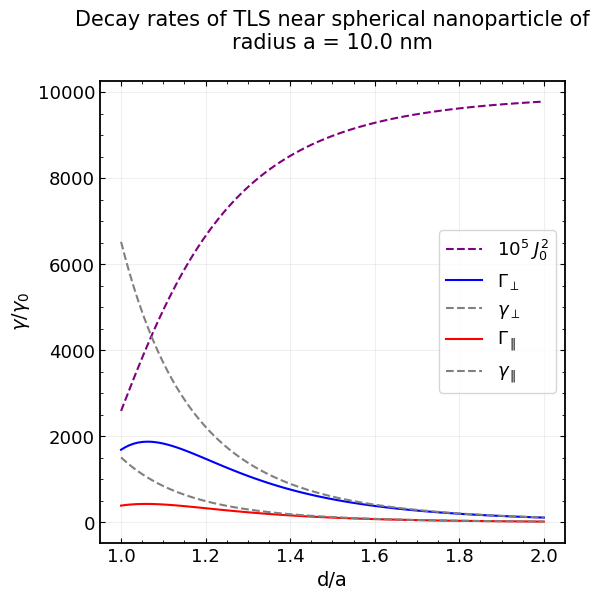

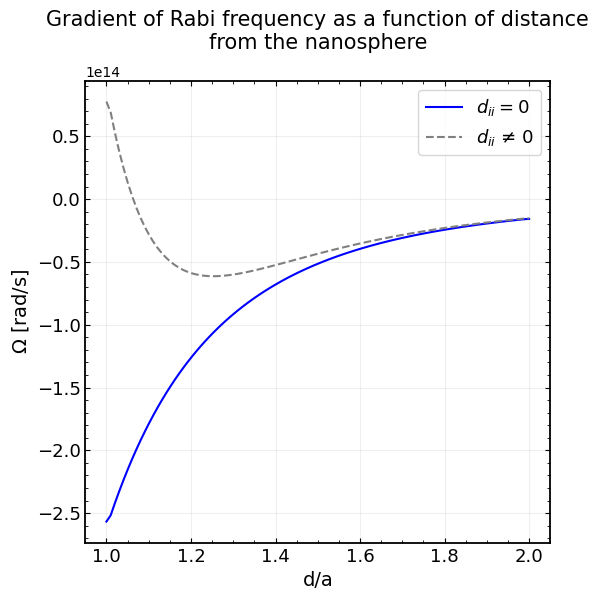

In [9]:
# Decay rates
a = 10e-9 # in nm
lam = 0.36  # emission wavelength in meters (360 nm)
index = np.where(ref_lam_silver == lam)
mval = m_silver[index][0]
dpoints = x_arr*1e-9 #[in m]
A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = gamma_factors(dpoints, mval, lam*1e-6, a, n = 1, order = 1, \
                                                                                      plot = False)
general_plot_style(x = [dpoints/a,dpoints/a,dpoints/a,dpoints/a,dpoints/a], y = [(10000*J_factor**2),(J_factor**2)*gamma_norm, \
                   gamma_norm, (J_factor**2)*gamma_tang, gamma_tang], figsize = [6,6], \
                   legendlabels = ['$10^5 \; J_0^2$','$\Gamma_{\perp}$', '$\gamma_{\perp}$', '$\Gamma_{\, \|}$', '$\gamma_{\, \|}$'], \
                   colors = ['purple', 'blue', 'grey', 'red', 'grey'], xlabel = 'd/a', ylabel = '$\gamma / \gamma_0$', \
                   ls = ['--','solid', '--', 'solid', '--'], \
                   title = f'Decay rates of TLS near spherical nanoparticle of radius a = {a*10**9} nm', \
                   filename = 'decay_rates.jpg', savefig = True)
general_plot_style(x = [r_arr/(r*1e3), r_arr/(r*1e3)], y = [np.gradient(omega_np), np.gradient(omega)], \
                   legendlabels = ['$d_{ii} = 0$', u'$d_{ii}$ \u2260 $0$'], colors = ['blue', 'grey'], \
                   ls = ['solid', '--'], ylims = None, xlabel = 'd/a', ylabel = '$\Omega$ [rad/s]', \
                   title = 'Gradient of Rabi frequency as a function of distance from the nanosphere', figsize = [6,6], \
                   filename = 'rabi_frequency.jpg', savefig = True)

### Change of the Rabi frequency of the TLS as a function of distance and incident field

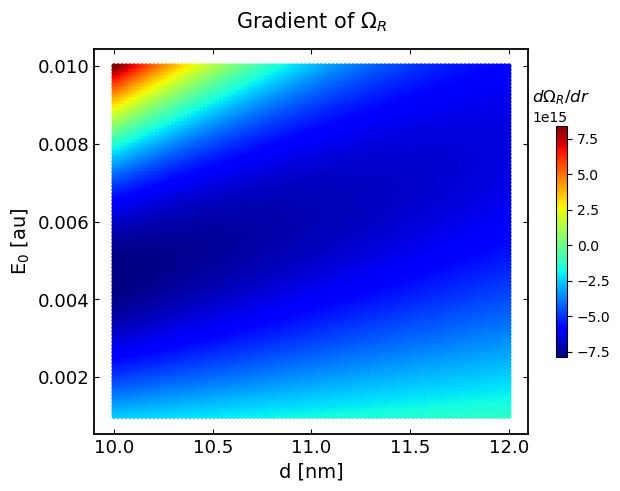

In [10]:
def rabi_colorbar(x_points, y, z, refr_ind, lam_list, r, E0s = np.linspace(0.001, 0.01, 100), n = 1, lam_value = 0.36, \
                  print_vals = False, correction = True):

    y_vals = np.ones_like(x_points)*y
    r_arr = np.sqrt(x_arr**2 + y_vals**2)
    Evals = np.zeros((len(x_points), len(E0s)), dtype = 'float')
    rs = np.zeros((len(x_points), len(E0s)), dtype = 'float')
    colors = np.zeros((len(x_points), len(E0s)), dtype = 'float')

    ind = 0
    for j in E0s:
        J_factor, E, omega_np, omega = rabi_frequency(x_points = x_points, y = y, z = z, E_0 = j, refr_ind = refr_ind, \
                                           lam_list = lam_list, r = r, n = n, lam_value = lam_value, print_vals = False)
        Evals[:,ind] = E / (5.14220675112*1e11)
        rs[:,ind] = r_arr
        if correction:
            colors[:,ind] = np.gradient(omega_np, r_arr/(r*1e3))
        else:
            colors[:,ind] = np.gradient(omega, r_arr/(r*1e3))
        ind += 1
        
    fig, ax = plt.subplots(1,1, figsize = (7, 5))
    plt.scatter(rs, Evals, c=colors, cmap='jet', label = 'full', marker = '.')
    ax.set_ylabel('E$_0$ [au]', fontsize=14)
    ax.set_xlabel('d [nm]', fontsize=14)
    ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
    cbar = plt.colorbar(shrink = 0.6) #, ticks = [0.0,3e16,6e16])
    cbar.ax.set_title(r'$d\Omega_R / dr$')
    ax.set_title('Gradient of $\Omega_R$', fontsize = 15, pad = 15)
    
x_arr = np.linspace(1.0, 1.2, 100) * 10 # nm
y_arr = np.array([0.0]) 
rabi_colorbar(x_points = x_arr, y = y_arr[0], z = 1e-15, refr_ind = m_silver, lam_list = ref_lam_silver, \
              r = r, n = 1, lam_value = 0.36, print_vals = False, correction = False)

### Evolution of the TLS

#### Original Hamiltonian

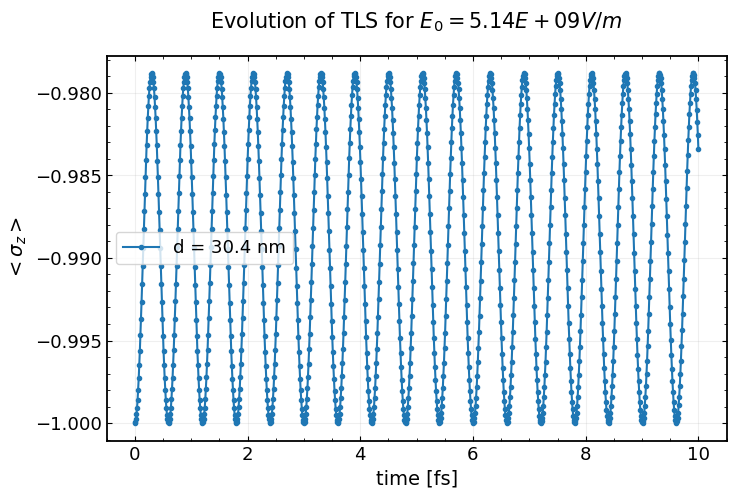

In [11]:
qutip_integration(m_silver, ref_lam_silver, x_points = np.array([30.4*(10**-9)]), E_0 = 0.01, tf = 10e-15)

#### Transformed Hamiltonian

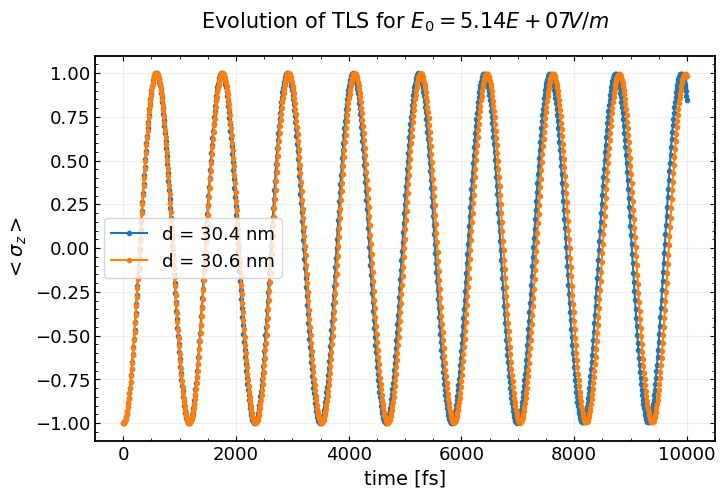

In [12]:
qutip_integration(m_silver, ref_lam_silver, x_points = np.array([30.4*(10**-9), 30.6*(10**-9)]), E_0 = 0.0001, \
                  tf = 10000e-15, transformed_H = True)